In [10]:
import sys
sys.path.append('../')

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from utils.constraint import *

DATA_PATH = "/dust3r/masked_dust3r/data/jackal_training_data_0"

with open(os.path.join(DATA_PATH, "transforms.json"), "r") as f:
    transforms = json.load(f)

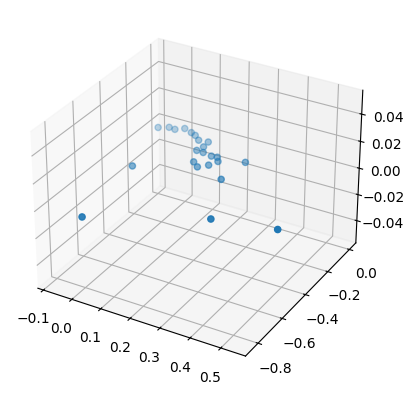

In [15]:
points = []
for frame in transforms["frames"]:
    tf = frame["transform_matrix"]
    tf = np.array(tf).reshape(4, 4)
    points.append(tf[0:3, 3])

points = np.array(points)
points = np.array(points)

# Plot the points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])


plt.show()